PC

## -*- coding: utf-8 -*-
# PC_

## Import

In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F  # F.mse_loss
import torch.optim as optim
from torchvision import transforms, utils, datasets
from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler, WeightedRandomSampler
from torch.utils.data import TensorDataset, DataLoader  # for batch and split Xtrain Ytrain dataset

import scipy
import scipy.ndimage as nd
from scipy.stats import norm
from scipy.optimize import minimize

from locale import format
from dataclasses import dataclass, MISSING

import seaborn as sns
import plotly.graph_objects as go


from scipy.interpolate import griddata
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# from scipy.sparse import identity
from icecream import ic  # for debugging. print variable name

## !!!!! To get the parameters
from PC_Parameters import default_parameters_network

pars = default_parameters_network()


{'ae': 18.26, 'be': -5.38, 'hme': 78.67, 'ai': 21.97, 'bi': -4.81, 'hmi': 125.62, 'taue': 0.005, 'taui': 0.005, 'tauNMDA': 0.1, 'tauGABA': 0.005, 'tauAMPA': 0.002, 'gamma': 0.641, 'sigma': 0.0007, 'I0e': 0.2346, 'I0i': 0.17, 'sigmaIn': 3, 'sigmaEI': 3, 'sigmaInh': [0.2, 3], 'I_ext': 0.0, 'c_dash': 90, 'mu0': 30, 'Jext': 0.01, 'I1': 0.57, 'I2': 0.029999999999999992, 'Jee': 0.2, 'Jie': 0.2, 'Jei': 1.4, 'Jii': 6.7, 'Jin': 0.008, 'Jiq': 0.85, 'Jes': 3.5, 'Jsi': 0.12, 'Jem': 2.2, 'I_noise': array([[ 0.00040415],
       [-0.00055782],
       [-0.0003215 ],
       [-0.00032575]]), 'T': 3, 'dt': 2e-05, 'r_init': 0.2, 'range_t': array([0.00000e+00, 2.00000e-05, 4.00000e-05, ..., 2.99994e+00,
       2.99996e+00, 2.99998e+00]), 'Lt': 150000, 'NumN': 20, 'f': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20]), 'In0': 0, 'InMax': 50, 'Iq0': 0, 'IqMax': 10}


## Functions
### Basics ones

In [2]:
#### 2- Input/Output function

def plot_io(x, y, sign):
    if sign == "+":
        sign_name = 'Excitatory'
        label = "ae={0}, be={1}, hme={2}"
        a, b, hm = pars['ae'], pars['be'], pars['hme']
        color = "k"
    elif sign == "-":
        sign_name = 'Inhibitory'
        label = "ai={0}, bi={1}, hmi={2}"
        a, b, hm = pars['ai'], pars['bi'], pars['hmi']
        color = "r"

    plt.plot(x, y, color, label=label.format(a, b, hm))

    plt.xlabel("Input values - nA")
    plt.ylabel("Spike Frequency - Hz")
    plt.xlim([-0.01, 1])
    plt.title("Input-output function")
    # plt.title("{0} Input-output function".format(sign_name))
    plt.legend()


def plot_r(range_sim, r_e, r_i, param, xlim_ar=None):
    label_e = "Excitatoty  Jee={0}, Jei={1}"  # , I1={2}"
    label_i = "Inhibitory  Jii={0}, Jie={1}"  # , I2={2}"
    plt.plot(range_sim, r_e, "r", label=label_e.format(param.Jee, param.Jei))  # , param.I1 #, param.In
    plt.plot(range_sim, r_i, "orange", label=label_i.format(param.Jii, param.Jie))  # , round(param.I2, 2)))

    plt.xlabel("Time - ms")
    plt.ylabel("Spike Frequency - Hz")
    if xlim_ar != None:
        plt.xlim(xlim_ar)  # [0, .1]
    plt.title("Firing rate of the NMDA and GABA populations")
    plt.legend()


def plot_s(range_sim, S_e, S_i, param, xlim_ar=None):
    label_e = "Excitatoty  Jee={0}, Jei={1}"  # , I1={2}"
    label_i = "Inhibitory  Jii={0}, Jie={1}"  # , I2={2}"
    plt.plot(range_sim, S_e, "olive", label=label_e.format(param.Jee, param.Jei))  # , param.I1
    plt.plot(range_sim, S_i, "green", label=label_i.format(param.Jii, param.Jie))  # , round(param.I2, 2)
    if xlim_ar != None:
        plt.xlim(xlim_ar)
    plt.xlabel("Time - ms")
    plt.ylabel("Open channel")
    # plt.xlim([0, .1])
    plt.title("Average open channel for the NMDA and GABA populations")
    plt.legend()


# 2- Plot HeatMap of firing rate function
def HeatMap(rE, rI, J=None):
    if J == None:
        J = [.00989, 0.0081, .1, .87, .00081]  # J = dict(Jin=.008, Jee= .2, Jie=.2, Jei=1.4, Jii=6.7)
    if type(J) == dict:
        J = np.array(list(J.values()))

    rE_df = pd.DataFrame(rE.T)  # to get time vs pop
    rI_df = pd.DataFrame(rI.T)

    rE_df.index.name, rI_df.index.name = ["Excitatory Population", "Inhibitory Population"]
    rE_df.columns.name, rI_df.columns.name = ["Time s", "Time s"]
    # print(rE_df.loc[[10]])

    # set context for the upcoming plot
    sns.set_context("notebook", font_scale=.8, rc={"lines.linewidth": 2.5, 'font.family': 'Helvetica'})

    fig, (axA, axB) = plt.subplots(2, 1, figsize=(6, 6))

    sns.heatmap(rE_df, ax=axA, cmap="viridis")
    sns.heatmap(rI_df, ax=axB)
    axA.set_title(f"Firing rate in Hz of exc populations over time. Jie: {J[2]}, Jee: {J[1]}, Jin: {J[0]}",
                  fontdict={"fontsize": 10})
    axB.set_title(f"Firing rate in Hz of inh populations over time. Jei: {J[3]}, Jii: {J[4]}",
                  fontdict={"fontsize": 10})
    plt.tight_layout()

    plt.show()


# Filters gauss and Dog and LoG
def gaussian_filter(s, N):
    k = np.arange(1, N + 1)
    n = 1 / (np.sqrt(2 * np.pi) * N * s)
    gaussW = n * np.exp(-(k - k[:, np.newaxis]) ** 2 / (2 * s ** 2))
    gaussW2 = gaussW / (.009 ** 2 / np.max(gaussW))  # 1
    return gaussW2


def dog_filter(sOut, N):
    sIn = sOut / 30
    k = np.arange(1, N + 1)
    gaussIn = np.exp(-(k - k[:, np.newaxis]) ** 2 / (2 * sIn ** 2))
    gaussOut = np.exp(-(k - k[:, np.newaxis]) ** 2 / (2 * sOut ** 2))
    dog = gaussOut - gaussIn
    if np.max(dog) == 0 or None:
        print('zero max')
        dog = 0
    else:
        dog = dog / (.042 ** 2 / np.max(dog))  # .0088
    return dog


def LoG_filter(s, N):
    x_lap = np.eye(N)
    lapl_filter = nd.gaussian_laplace(x_lap, sigma=(s, s))
    return lapl_filter


def dLogGaus(s=.61, N=20):
    dig = LoG_filter(s, N) + gaussian_filter(.019 * s, N)
    return dig


"""### Differentiable function for back propagation

To avoid non-differentiable araising from discontinuity of the function, I "relax" (smoothen) the where() expression by using a sigmoid instead
*   with grad_fn:
*   if I get : > <SumBackward1 object at 0x7f79da0b9520> # differentiable
*   else I get none
"""


def relu_stim(x, stim):
    return torch.nn.functional.relu(1.0 - torch.abs(x - stim),
                                    inplace=False)  # inplace = False to avoid implace operation




def Dirac(A, N=pars["NumN"]):
    y = scipy.signal.unit_impulse(N, idx=(torch.max(torch.argmax(A))))  # , dtype= <class 'float'>)
    return torch.tensor(y)



"""### Try Normalization to "make it proba"
"""


def make_it_proba(r_e):
    sum_r_e = torch.sum(r_e, 1).reshape(r_e.shape[0], 1)
    prob_r = torch.div(r_e, sum_r_e)  
    print(prob_r.grad_fn)
    prob_r[prob_r != prob_r] = 0.05  # to replace nan to 1/20 - to sum to 1
    # print("should sum to 1:", torch.sum(prob_r, 1)) #to check that it worked

    return prob_r.reshape(r_e.shape[0], r_e.shape[1])  # log or not log?


def make_it_proba_1d(r_e):
    sum_r_e = torch.sum(r_e)
    prob_r = torch.div(r_e, sum_r_e)  # torch.transpose(r_e, dim0=0 ,dim1=1) poses a problem
    prob_r[prob_r != prob_r] = 0.05  # to replace nan to 1/20 - to sum to 1
    print("should sum to 1:", torch.sum(prob_r)) #to check that it worked

    return prob_r


def log_proba(proba_r):
    return torch.log(proba_r)


"""### Try softmax to "make it proba"
"""


def softmax(x):
    return torch.exp(x) / torch.sum(torch.exp(x), axis=1, keepdims=True)

def softmax1D(x):
    return torch.exp(x) / torch.sum(torch.exp(x))

"""### Get the expected stimuli : matrix of 1 where stimuli 0 elsewhere"""


# find the stimuli for every X = stim dataset
def get_stimuli_input1D(X_train_tensor):  # input of the shape Xtrain_tensor[5,:,:]
    Xargmax = torch.argmax(X_train_tensor)#, dim=1)
    Xmax = torch.max(Xargmax)
    return Xmax


# replace where function by relu functio which is differentiable
"""def get_expected_Y_relu(X_train_tensor):
    x_t = torch.transpose(X_train_tensor, 0, 1)
    dirac_2d = torch.zeros(x_t.shape)
    stim = get_stimuli_input(
        X_train_tensor)  # input of the shape Xtrain_tensor[5,:,:] # here get_stimuli not differenciable

    for pop, t in enumerate(x_t):
        tpop = torch.tensor(pop)
        dirac_2d[pop, :] = torch.nn.functional.relu(1.0 - torch.abs(tpop - stim), inplace=False).requires_grad_(True)
    dirac_2d = torch.transpose(dirac_2d, 1, 0)
    return dirac_2d"""


def get_expected_Y_relu_1d_where(X_train_tensor):
    stim = get_stimuli_input1D(X_train_tensor)
    dirac_1d = torch.zeros(X_train_tensor.shape)
    # Calculate the difference between tpop and stim
    for pop in enumerate(X_train_tensor):
        dirac_1d[pop[0]] = torch.where(pop[0] == torch.tensor(stim), torch.tensor(1.0), torch.tensor(0.0)).requires_grad_(False)#true #not differenciable
    return dirac_1d




## Class

### 1- Basic classes

In [3]:


# ***************** CLASS ***************************************

@dataclass
class Parameter:
    # °°° Load the parameters °°°

    taue: float = pars["taue"]
    ae: float = pars['ae']
    be, hme, I_noise = pars['be'], pars['hme'], pars['I_noise']
    Jee: float = pars['Jee']
    taui, ai, bi, hmi = pars['taui'], pars['ai'], pars['bi'], pars['hmi']
    Jii: float = pars['Jii']
    Jei: float = pars['Jei']
    Jie: float = pars['Jie']
    Jes, Jsi = pars['Jes'], pars['Jsi']
    Jiq: float = pars['Jiq']  # 0.85; #nA
    Jin: float = pars['Jin']
    tauNMDA, tauAMPA, tauGABA = pars['tauNMDA'], pars['tauAMPA'], pars['tauGABA']
    gamma: float = pars['gamma']  # nmda coupling parameter from brunel
    c_dash = pars['c_dash']
    sigma = pars['sigma']  # param.sigma = .0007 for Noise
    I_noise = pars['sigma'] * np.random.randn(3, 1)
    I1 = pars['Jext'] * pars['mu0'] * (1 + pars['c_dash'] / 100)
    I2 = pars['Jext'] * pars['mu0'] * (1 - pars['c_dash'] / 100)
    # I1, I2 = pars['I1'], pars['I2']

    sigmaIn = pars['sigmaIn']

    # Input parameters
    In0 = pars['In0']  # % Spontaneous firing rate of input populations (Hz)
    InMax = pars['InMax']  # % Max firing rate of input populations (Hz)
    Iq0 = pars['Iq0']  # % Spontaneous firing rate of feedback populations (Hz)
    IqMax = pars['IqMax']  # % Max firing rate of feedback populations (Hz)

    # Gaussian filter
    # sIn = pars['sigmaInh'][0]
    # sOut = pars['sigmaInh'][1]

    def __init__(self, sEI, sIn, sOut, N):  # sEI=4, sIn=.2, sOut=1.2,
        # Weights (from gaussian filter)
        self.N = N  # pars['NumN']
        self.wei = torch.tensor(dog_filter(sOut, int(N)), dtype=torch.float32)   # .astype( torch.float32))  # , dtype='float64'# fun.dLogGaus(.61, N)  #fun.dog_filter(sIn, sOut, N)#gaussian_filter(sEI, N)
        self.wii = torch.tensor(np.eye(int(N)), dtype=torch.float32) #.astype(torch.float32))  # dog_filter(sIn, sOut, N)#np.eye(N) #
        self.wie = torch.tensor(gaussian_filter(sEI, int(N)), dtype=torch.float32) #.astype(torch.float32))  # dog_filter(sIn, sOut, N)
        self.wes = torch.tensor(np.eye(int(N)), dtype=torch.float32)  #.astype(torch.float32))  # Identity matrix
        self.f = np.arange(1, N + 1)
        self.sEI = sEI
        self.sIn = sIn
        self.sOut = sOut

    def reset(self):  # https://stackoverflow.com/questions/56878667/setting-default-values-in-a-class

        for name, field in self.__dataclass_fields__.items():
            if field.default != MISSING:
                setattr(self, name, field.default)
            else:
                setattr(self, name, field.default_factory())


# °°° Time of the simulation °°°
class Simulation:
    def __init__(self, dt, T):
        self.dt = dt
        self.T = T
        self.range_t = (np.arange(0, self.T, self.dt))
        self.Lt = self.range_t.size

    def printSim(self):
        print("T time step of the simulation (dt): ", self.dt, "  Duration of simulation S (T): ", self.T,
              "Length of the time frame (Lt): ", self.Lt)


#  °°° Initialisation of the variables °°°

class Stim:
    def __init__(self, param, simu, f, ISI=1, dur=0.2):  # 8 #[10]
        self.f = f  # array of frequency stimulus types
        self.ISI = ISI  # inter-stimulus interval
        self.dur = dur  # duration in s of a specific stimulus segment . The time the frequency fi ll be maintained in the f array
        self.tail = 0
        self.predDt = 0
        self.pred = 0
        self.InMax = param.InMax
        self.In0 = param.In0

        # Instantaneous frequency
        f_instant = np.zeros((int(self.ISI / simu.dt) + 1, 1))  # size ISI : 1 /dt : 1000

        for fx in self.f:
            fx_array = np.concatenate((np.ones((int(self.dur / simu.dt), 1)) * fx,
                                       # just 1 frequency of 8 . # inter-stim interval is aslong as stim interval
                                       np.zeros((int(self.ISI / simu.dt),
                                                 1))))  # so I get 1 list with 1000 lists containing 8 and 1000 lists containing 0
        f_stim = np.vstack((f_instant, fx_array))  # stack vertically these arrays # [0] *1000 , [8]*1000, [0]*1000
        self.f_stim = f_stim[1:]  # 1400*1

    # bottom up sensory Input # duration 1sec
    def sensoryInput(self, parameter, simu, sigmaIn=None, paramf=None, f_stim=None, InMax=None, In0=None):
        # paramf = np.arange(1, 101)
        w = np.exp(-(((paramf or parameter.f) - (f_stim or self.f_stim)) ** 2) / (
                2 * (sigmaIn or parameter.sigmaIn) ** 2))  # pars['f'] = 1:N

        # totalAct = w.sum(axis = 1) #sum over each row
        # norm_w = (w.T / totalAct).T # elementwise division
        In = np.where(f_stim or self.f_stim > 0, (InMax or self.InMax) * w + (In0 or self.In0),
                      0)  # if stim >0 give InMax * weight + In0 otherwise give 0
        if self.tail != 0:
            tail_zeros = np.zeros((parameter.N, int(self.tail / simu.dt)))
            In = np.hstack((In, tail_zeros))

        range_sim = np.arange(1, In.shape[0] + 1)
        self.In = In
        self.w = w
        self.sigmaIn = sigmaIn

        return In, range_sim, w, sigmaIn

    def printStim(self):
        print("frequence of stimulus f:", self.f, "  ISI:", self.ISI, " Size In:", self.In.shape, "Size w:",
              self.w.shape, "  f_stim:", self.f_stim.shape,
              "sigmaIn:", self.sigmaIn)


### 2- Model Classes

My model without time

In [4]:
class MyModel_notime(nn.Module):
    def __init__(self): 
        super(MyModel_notime, self).__init__()
      
        #--- Define other model parameters, layers, or components here if needed
        self.dt = torch.tensor(1e-4) #sim.dt 
        self.N = 20 
        self.taue = self.taui = torch.tensor(0.005)
        
        self.Jee = nn.Parameter(torch.tensor(0.0720000000, requires_grad= True, dtype= torch.float64))#, requires_grad=False, dtype=torch.float32)#I replaced .072 by 0.072
        ic(self.Jee.grad_fn)
        self.Jei =nn.Parameter(torch.tensor(0.004, requires_grad= True, dtype= torch.float64)) 
        self.Jie = nn.Parameter(torch.tensor(0.05, requires_grad=False, dtype=torch.float64))
        self.Jii = torch.tensor(0.6)
        self.Jin = nn.Parameter(torch.tensor(0.00695, requires_grad= True, dtype=torch.float64))
        self.newfactor = nn.Parameter(torch.tensor(10000., requires_grad= True, dtype=torch.float64)) #I have to scale this mock model with this new factor

    def forward(self, In):
        #--- Initialize model variables here
        prev_r_e = torch.zeros(self.N) # torch.ones(self.N) shows more obvious results
        prev_r_i = torch.zeros(self.N) 
        ic(prev_r_e.grad_fn)
      
        #--- Compute values of interest
        #the operation Jee_re = self.Jee * prev_r_e => triggers inplace error
        i_tot_e = torch.add(torch.add(torch.mul(prev_r_e, self.Jee), prev_r_i.mul(self.Jie)), In.mul(self.Jin))
        ic(i_tot_e.grad_fn)
        dr_e_dt = torch.div(torch.add(torch.neg(prev_r_e), i_tot_e), self.taue)
        ic(dr_e_dt.grad_fn)
      
        r_e = torch.multiply(torch.multiply(torch.add(prev_r_e, dr_e_dt), self.dt), self.newfactor)
        ic(r_e.grad_fn, r_e.shape)
      
            
        return r_e
    
    

## Call the classes to make the Input matrix (In)


In [5]:
## Parameters used to create In
N = 20
# \\\\\\\\\\\ Parameters
param = Parameter(N=20, sIn=.1, sOut=3., sEI=.2)
# \\\\\\\\\\\ Simulation time
simu = Simulation(1e-4, .4)  # dt #rangeSim #dur = 2s

# \\\\\\\\\\\ Bottom up sensory input
stimuli = Stim(param, simu, dur=.3, f=[8], ISI=.05)  # dur = 1s Isi=1s
In, range_sim, w, sigmaIn = stimuli.sensoryInput(param, simu, sigmaIn=2.)

J1 = {'Jee': 0.072, 'Jei': 0.004, 'Jie': 0.05, 'Jii': 0.6, 'Jin': 0.00695}
J_list = list(J1.keys())

## Optimization steps

### Parameters Initialization

In [9]:
# +++++++++++++++++++++++++ Initialize the Model ++++++++++++++++++++++++++++
mymodel2 = MyModel_notime()

# +++++++++++++++++++++++++ Optimizer ++++++++++++++++++++++++++++
learning_rate = 0.1
optimizer = optim.SGD(mymodel2.parameters(),
                      lr=learning_rate)
# +++++++++++++++++++++++++ Epochs +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
num_epochs = 4

# +++++++++++++++++++++++++ Inputs + Labels +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
X_input = make_it_proba_1d(torch.tensor(stimuli.In)[1000,:]) #make I at time 1000ms a probability function
Y_target = get_expected_Y_relu_1d_where(X_input) #get the expected dirac delta for our particular Input
losses = torch.zeros(num_epochs) # used to plot the loss at the end

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ RUN forward pass  ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
r_enew = mymodel2.forward(X_input)

ic| self.Jee.grad_fn: None
C:\Users\knzga\AppData\Local\Temp\ipykernel_1336\2420618407.py:205: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dirac_1d[pop[0]] = torch.where(pop[0] == torch.tensor(stim), torch.tensor(1.0), torch.tensor(0.0)).requires_grad_(False)#true #not differenciable
ic| prev_r_e.grad_fn: None
ic| i_tot_e.grad_fn: <AddBackward0 object at 0x0000025E492FBAF0>
ic| dr_e_dt.grad_fn: <DivBackward0 object at 0x0000025E492FBAF0>


ic| r_e.grad_fn: <MulBackward0 object at 

should sum to 1: tensor(1., dtype=torch.float64)


0x0000025E492FBAF0>
    r_e.shape: torch.Size([20])


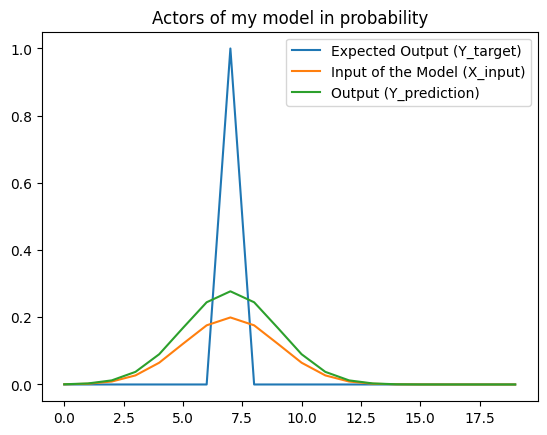

In [10]:

plt.plot(np.arange(0,20),Y_target.detach().numpy(), label = "Expected Output (Y_target)")
plt.plot(np.arange(0,20), X_input.detach().numpy(), label = "Input of the Model (X_input)")
plt.plot(np.arange(0,20),r_enew.detach().numpy(), label = "Output (Y_prediction)")

plt.title("Actors of my model in probability")
plt.legend()

### Optimization steps

In [11]:
# +++++++++++++++++++++++++ Problems investigations +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# import tracemalloc
# tracemalloc.start()
#mymodel2.train()

# +++++++++++++++++++++++++ Optimization loop +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
with torch.autograd.set_detect_anomaly(True):
    for epoch in range(num_epochs):
        # Create a new input tensor for each epoch
        X_input.requires_grad = False 
        # Clear the gradients 
        optimizer.zero_grad()

        # calculate output
        Y_prediction = mymodel2(X_input) 
        ic(Y_prediction.grad_fn)
        
        # calculate loss
        loss1D = (torch.sum((Y_prediction - Y_target)**2))  
        ic(loss1D.grad_fn)
        loss1D.backward()
        
        optimizer.step()

        losses[epoch] = loss1D
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss1D}, Loss_grad: {loss1D.grad}')  # .item()
        for i, par in enumerate(mymodel2.parameters()):
           ic(J_list[i], par, par.grad)
     


ic| prev_r_e.grad_fn: None


ic| i_tot_e.grad_fn: <AddBackward0 object at 0x0000025E4931EC20>
ic| dr_e_dt.grad_fn: <DivBackward0 object at 0x0000025E4931EC20>
ic| r_e.grad_fn: <MulBackward0 object at 0x0000025E4931EC20>
    r_e.shape: torch.Size([20])
ic| Y_prediction.grad_fn: <MulBackward0 object at 0x0000025E4931EC20>
ic| loss1D.grad_fn: <SumBackward0 object at 0x0000025E4931EC20>
C:\Users\knzga\AppData\Local\Temp\ipykernel_1336\3206723908.py:26: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at aten\src\ATen/core/TensorBody.h:494.)
  print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss1D}, Loss_grad: {loss1D.gra

Epoch [1/4], Loss: 0.7179871777943663, Loss_grad: None


ic| J_list[i]: 'Jin'
    par: Parameter containing:
         tensor(10000.0000, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(-9.4539e-07, dtype=torch.float64)
ic| prev_r_e.grad_fn: None
ic| i_tot_e.grad_fn: <AddBackward0 object at 0x0000025E4931EC20>
ic| dr_e_dt.grad_fn: <DivBackward0 object at 0x0000025E4931EC20>
ic| r_e.grad_fn: <MulBackward0 object at 0x0000025E4931EC20>
    r_e.shape: torch.Size([20])
ic| Y_prediction.grad_fn: <MulBackward0 object at 0x0000025E4931EC20>
ic| loss1D.grad_fn: <SumBackward0 object at 0x0000025E4931EC20>
ic| J_list[i]: 'Jee'
    par: Parameter containing:
         tensor(0.0720, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(0., dtype=torch.float64)
ic| J_list[i]: 'Jei'
    par: Parameter containing:
         tensor(0.0040, dtype=torch.float64, requires_grad=True)
    par.grad: None
ic| J_list[i]: 'Jie'
    par: Parameter containing:
         tensor(0.0500, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(0.,

Epoch [2/4], Loss: 104.94302214906057, Loss_grad: None


=torch.float64)
ic| J_list[i]: 'Jin'
    par: Parameter containing:
         tensor(9999.9978, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(0.0219, dtype=torch.float64)
ic| prev_r_e.grad_fn: None
ic| i_tot_e.grad_fn: <AddBackward0 object at 0x0000025E4931EC20>
ic| dr_e_dt.grad_fn: <DivBackward0 object at 0x0000025E4931EC20>
ic| r_e.grad_fn: <MulBackward0 object at 0x0000025E4931EC20>
    r_e.shape: torch.Size([20])
ic| Y_prediction.grad_fn: <MulBackward0 object at 0x0000025E4931EC20>
ic| loss1D.grad_fn: <SumBackward0 object at 0x0000025E4931EC20>
ic| J_list[i]: 'Jee'
    par: Parameter containing:
         tensor(0.0720, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(0., dtype=torch.float64)
ic| J_list[i]: 'Jei'
    par: Parameter containing:
         tensor(0.0040, dtype=torch.float64, requires_grad=True)
    par.grad: None
ic| J_list[i]: 'Jie'
    par: Parameter containing:
         tensor(0.0500, dtype=torch.float64, requires_grad=True)
    par.grad: 

Epoch [3/4], Loss: 132508524.9072903, Loss_grad: None


ic| J_list[i]: 'Jin'
    par: Parameter containing:
         tensor(7349.9490, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(26500.4879, dtype=torch.float64)
ic| prev_r_e.grad_fn: None
ic| i_tot_e.grad_fn: <AddBackward0 object at 0x0000025E2F0B6710>
ic| dr_e_dt.grad_fn: <DivBackward0 object at 0x0000025E2F0B6710>
ic| r_e.grad_fn: <MulBackward0 object at 0x0000025E4B9C02B0>
    r_e.shape: torch.Size([20])
ic| Y_prediction.grad_fn: <MulBackward0 object at 0x0000025E4CD19AE0>
ic| loss1D.grad_fn: <SumBackward0 object at 0x0000025E4CD19AE0>
ic| J_list[i]: 'Jee'
    par: Parameter containing:
         tensor(0.0720, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(0., dtype=torch.float64)
ic| J_list[i]: 'Jei'
    par: Parameter containing:
         tensor(0.0040, dtype=torch.float64, requires_grad=True)
    par.grad: None
ic| J_list[i]: 'Jie'
    par: Parameter containing:
         tensor(0.0500, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(0., d

Epoch [4/4], Loss: 91008903828278.84, Loss_grad: None


ic| J_list[i]: 'Jin'
    par: Parameter containing:
         tensor(-2.4764e+09, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(2.4765e+10, dtype=torch.float64)


### Model evaluation

#### Loss over epochs

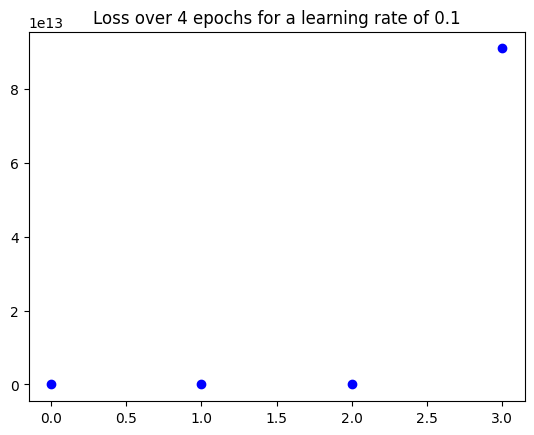

In [12]:

## +++++++++++++++++++++++++ Loss over epochs +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
plt.plot(np.arange(losses.shape[0]), losses.detach().numpy(), 'bo', label='Training loss')
#plt.ylim([0.7179871796,0.71798718])
#plt.axhline(y=0.7179871780183, color='blue', linestyle='-', label='Training loss')

plt.title(f"Loss over {num_epochs} epochs for a learning rate of {learning_rate}")
plt.show()

#### Loss function observation

Text(0.5, 0.92, 'Loss function: squared difference')

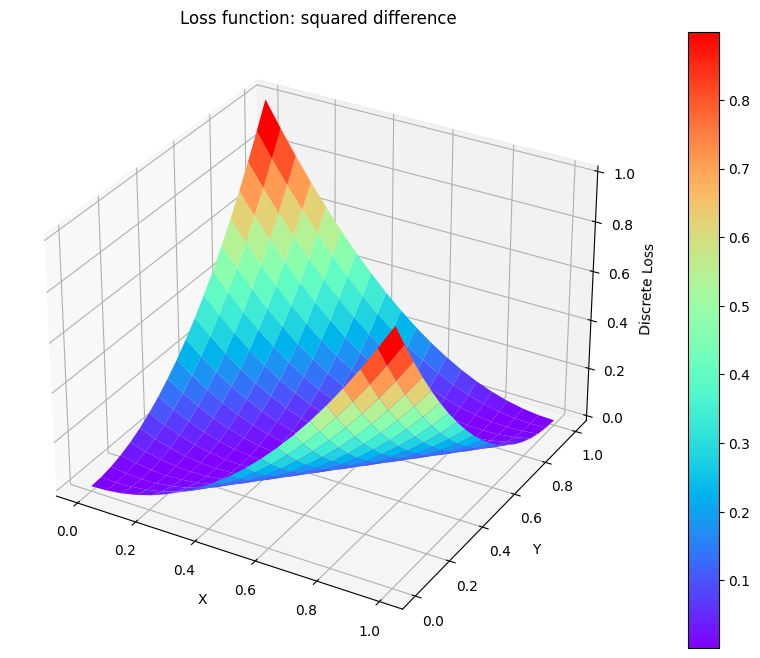

In [13]:

def discrete_loss(Y_prediction, Y_target):
    return (((Y_prediction - Y_target)**2))

grid_x, grid_y = np.mgrid[0:1:20j, 0:1:20j]

values = discrete_loss(grid_x, grid_y)
fig, ax = plt.subplots(nrows=1, ncols=1, num=0, figsize=(16, 8),
                       subplot_kw={'projection': '3d'})
pSurf = ax.plot_surface(grid_x, grid_y, values, rstride=1, cstride=1, cmap='rainbow')
#ax = fig.add_subplot(111, projection='3d')
#ax.plot_surface(x, y, z)
fig.colorbar(pSurf)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Discrete Loss')
ax.set_title("Loss function: squared difference")